# Assignment 3  - Part B  - TensorFlow - Primary


#### Roll Number: 20030012

You have a choice in Part B. You can either choose to do using TensorFlow or using Pytorch. Both are equally good and are widely used in industry.

You are only required to do one of them. It's upto you to decide which one. However, you can also do both. In case you do both, you have to choose one as primary and and other one as secondary. Your primary one will be marked as normal and secondary one will marked for a 10% bonus.

For example, if you do both and choose tensorflow as your primary attempt then you should primary in first heading of tensorflow notebook (Assignment 3  - Part B  - TensorFlow - Primary) and secondary (Assignment 3  - Part B  - Pytorch - Secondary) in pytorch notebook.

In case, you only do one then you just need to submit that notebook.

### Task Explanation

In this part we will implement, train and evaluate a neural network using tensorflow on wheat disease classification problem. 

Wheat rust is a devastating plant disease that affects many crops, reducing yields and affecting the livelihoods of farmers and decreasing food security across the continent. The disease is difficult to monitor at a large scale, making it difficult to control and eradicate.

The objective of this challenge is to build a machine learning algorithm to correctly classify if a plant is healthy, has stem rust, or has leaf rust.

### Let's Start

Make necessary imports here e.g. import cv2, import glob, etc

In [ ]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
# any other imports that you may require
import random
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D
from sklearn.metrics import confusion_matrix
import math

### Hyperparameters

You can play with these to improve accuracy on test data.

In [ ]:
batch_size = 32
epochs = 35
# learning_rate = 0.0001
learning_rate = 0.001

input_shape = (256,256,3)

### Data

Get Wheat Disease Data for training and testing

In [ ]:
!git clone https://github.com/MMFa666/WheatDiseaseDataset.git

Cloning into 'WheatDiseaseDataset'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 386.05 MiB | 48.48 MiB/s, done.
Checking out files: 100% (877/877), done.


Get paths for all the training images in the dataset and print the length of training_paths list. For this purpose you can use glob. You can have a look [here](https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/) on how to use glob.

In [ ]:
# code here
train_paths = []
for type_folder in glob.glob('/content/WheatDiseaseDataset/train/*'):
  for img_link in glob.glob(type_folder + '/*'):
    train_paths.append(img_link)

train_examples = len(train_paths)


Do the same for testing data images.

In [ ]:
# code here
test_paths = []
for type_folder in glob.glob('/content/WheatDiseaseDataset/test/*'):
  for img_link in glob.glob(type_folder + '/*'):
    test_paths.append(img_link)
test_examples = len(test_paths)


### Labels

In [ ]:
labels={}
labels['healthy_wheat'] = 0
labels['leaf_rust'] = 1
labels['stem_rust'] = 2

### Preprocessing

Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. In this task, we will only do normaliztion.

In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.


In [ ]:
def preprocessing_norm(images):
    return images/255

### Batch Generator

Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. 

For examples of batch_generators, you can have a look [here](https://www.geeksforgeeks.org/generators-in-python/) or [here](https://www.programcreek.com/python/?CodeExample=generate+batches). Essentially you have to the following:
- Shuffle the paths to get a uniform distribution in all batches.
- Divide paths into batches.
- Read image from the path. (Remeber cv2 reads image in BGR format.)
- Resize each image to input_shape.
- Extract label of the image from the image path using folder name. (Hint: You can do this by splitting the path.)
- One-hot encode the labels.
- Yield images and labels in tuple.



In [ ]:
# Batch generator function here.
def data_generator(file_path):

  batch_train_paths = [file_path[i:i+batch_size] for i in range(0,len(file_path),batch_size)] ## 21 batches 
  for batch in np.tile(batch_train_paths,epochs): ## generating/yielding batches by #of epochs x epoch step size = 30 * 21 = 630
    one_hot_labels = []
    imgs_list = []
    for path in batch:
      img = preprocessing_norm(cv2.imread(path))
      img.resize((input_shape)) ## (256,256,3)
      imgs_list.append(img)
      imgs_label = path.split('/')[4] ## getting label name
      one_hot_encoded_label = np.zeros(3)
      one_hot_encoded_label[labels[imgs_label]] = 1
      one_hot_labels.append(one_hot_encoded_label)
    yield np.array(imgs_list), np.array(one_hot_labels)



Initialize train data generator

In [ ]:
# code here
random.shuffle(train_paths)
generator = data_generator(train_paths)

### Training

Build model here. Use Functional API of tensorflow to this. You can have a look [here](https://www.tensorflow.org/guide/keras/functional) to understand how this works.

Model Architecture:
- See model.png for model architecture
- Filter size in each convolution layer is 3 except first convolution where it is 5.
- The stride in each convolution layer is 2.
- There is no padding in convolution layer.
- Dropout = 0.2 on each dropout layer.
- The last layer has softmax activation.
- The model should have 491,443 total parameters.


In [ ]:
# Code here
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(256, kernel_size=(5, 5), strides = (2,2), activation='relu', use_bias = True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(Conv2D(128, kernel_size=(3, 3), strides = (2,2),  activation='relu' ,use_bias = True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3), strides = (2,2),  activation='relu',use_bias = True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=(3, 3), strides = (2,2),  activation='relu',use_bias = True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(Conv2D(16, kernel_size=(3, 3), strides = (2,2),  activation='relu',use_bias = True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', use_bias=True))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',use_bias = True))
model.add(LeakyReLU(alpha=0.1)) 
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax',use_bias = True))

In [ ]:
#print model summary here
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 256)     19456     
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 256)     1024      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 126, 126, 256)     0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 128)       295040    
_________________________________________________________________
batch_normalization_6 (Batch (None, 62, 62, 128)       512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 62, 62, 128)      

Compile your model here. (Hint: use model.compile() ) See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) documentation or the above link to know how to do this. 

Use the following specifications:
- optimizer: Adam
- metrics: accuracy
- loss: categorical_crossentropy

In [ ]:
# Code here

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate= learning_rate ),
    metrics=["accuracy"],
)

Fit your model here. (Hint: use model.fit() ) See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation or the above link again to know how to do this.

In [ ]:

hist = model.fit(generator, steps_per_epoch = math.ceil(train_examples/batch_size), epochs=  epochs)


/usr/local/lib/python3.7/dist-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


Epoch 1/35
22/22 [==============================] - 60s 3s/step - loss: 1.2746 - accuracy: 0.3991
Epoch 2/35
22/22 [==============================] - 63s 3s/step - loss: 1.0832 - accuracy: 0.4146
Epoch 3/35
22/22 [==============================] - 63s 3s/step - loss: 0.9637 - accuracy: 0.5291
Epoch 4/35
22/22 [==============================] - 63s 3s/step - loss: 0.9690 - accuracy: 0.4787
Epoch 5/35
22/22 [==============================] - 63s 3s/step - loss: 0.8832 - accuracy: 0.5866
Epoch 6/35
22/22 [==============================] - 64s 3s/step - loss: 0.8560 - accuracy: 0.5886
Epoch 7/35
22/22 [==============================] - 65s 3s/step - loss: 0.8344 - accuracy: 0.6148
Epoch 8/35
22/22 [==============================] - 64s 3s/step - loss: 0.8321 - accuracy: 0.6125
Epoch 9/35
22/22 [==============================] - 65s 3s/step - loss: 0.8153 - accuracy: 0.5976
Epoch 10/35
22/22 [==============================] - 64s 3s/step - loss: 0.7425 - accuracy: 0.6540
Epoch 11/35
22/22 [

Plot the loss and accuracy graphs of training. Use hist.history['loss'] and hist.history['accuracy'] where hist is returned by model.fit()

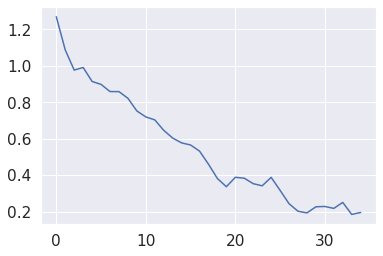

In [ ]:
# Loss Plot

plt.plot(hist.history['loss'])
plt.show()


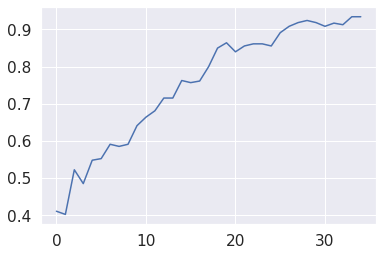

In [ ]:
# Accuracy Plot


plt.plot(hist.history['accuracy'])
plt.show()

### Evaluation

Now, we will evaluate our model on the test data.

First, let's read the test data using test_paths. Similar to what we did in batch_generator.

In [ ]:
# code here
test_Y = []
test_X = []
for path in test_paths:
  img = preprocessing_norm(cv2.imread(path))
  img.resize((input_shape)) ## (256,256,3)
  test_X.append(img)
  imgs_label = path.split('/')[4] ## getting label name
  one_hot_encoded_label = np.zeros(3)
  one_hot_encoded_label[labels[imgs_label]] = 1
  test_Y.append(one_hot_encoded_label)


Now, make predictions on test data. (Hint: use model.predict() ).

In [ ]:
# code here
preds = model.predict(np.array(test_X))

Extract class label from predictions. (Hint: you can use np.argmax() ).

In [ ]:
# code here
pred_labels = np.argmax(preds, axis=1)

Calculate and print accuracy.

In [ ]:
# code here
actual_labels = np.argmax(np.array(test_Y),axis=1)
print('accuracy is : ', ((pred_labels == actual_labels).sum() / len(actual_labels)) * 100)

accuracy is :  65.5367231638418


Calculate and print Confusion Matrix. Have a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for this.

In [ ]:
# code here
conf_mat = confusion_matrix(actual_labels, pred_labels)
print(conf_mat)

[[17  7  5]
 [ 5 47 20]
 [ 8 16 52]]


In [ ]:
def plot_confusion_matrix(conf_mat):
    classes = list(labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

Use the above function to plot confusion matrix here.

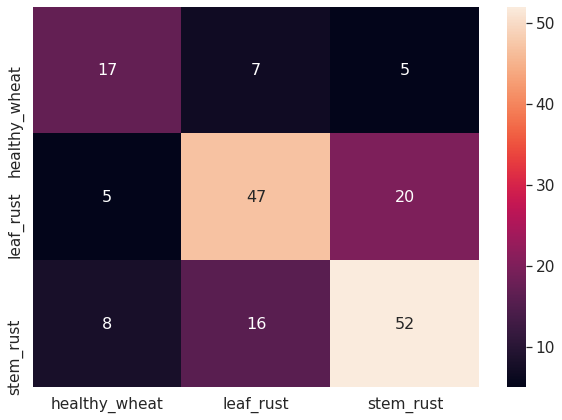

In [ ]:
# code below
plot_confusion_matrix(conf_mat)

### Questions



What is overfitting? How are we trying to prevent overfitting here?

Answer: Overfitting occurs when accuracy on training data set is quite high but low on test data set. It means that model is not generalizing for unseen data. Overfitting can be prevented using multiple ways including regularization, lowering number of features in train dataset, lower learning rate, and epochs number. Here we are preventing overfitting by keeping a balanced number of epochs i-e 30, if we set number of epochs b/w 50-100, it will lead to overfitting and training accuracy reaches to 99%.


What is class imbalance? How does it effect training? Does this training set have class imbalance? If yes, then show it (using numbers).

Answer: Class Imbalance occurs when there are unevenly distributed examples in the given classes. It can occur to that extent as well that there could be even a single example in minor class and thousands of examples in major class. Class Imbalance effects training because of bias predicting towards major classes and ignoring smaller classes. Therefore, samples belonging to minor classes are oftenly misclassified and this results in wrong predictions. 

This set doesnt have class imbalance because there are 80 examples for each class and more data that is being generated is also evenly generated for each class. Hence no class imbalance occurs here.